<a href="https://colab.research.google.com/github/01yeongju/2023_BigData_Analysis_Competition/blob/main/1_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 장애인콜택시 대기시간 예측

## 1. 데이터 전처리
* 1.데이터 탐색
    * 데이터 : 2015-01-01 ~ 2022-12-31 까지의 서울 장애인 콜택시 운행 정보  
    * 요일, 월, 계절, 연도별 운행 정보에 어떤 주기와 변화가 있는지 탐색해 봅시다.  
    → 목표 : 평균대기시간을 예측  
      
* 2.분석을 위한 데이터 구조 만들기
    * 문제정의 :
        * 전 날 콜택시 운행이 종료되었을 때, 다음 날 대기시간을 예측
        * 만약 다음 날 대기시간을 예측할 수 있다면, 일정 범위 내에서 배차를 조절할 수 있을 뿐만 아니라, 향후 교통약자의 이동 편의 증진을 위한 정책 수립 및 개선에 기여할 수 있음

    * 데이터 구조 :
        * 분석 단위 : 일별 데이터
        * 주어진 데이터 : 장애인 콜택시 운행 정보, 서울시 날씨
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주
            * 예를 들어,
                * 2020-12-23 의 날씨 데이터는 전 날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터
        * 휴무일 데이터는 패키지를 통해서 다운받아 사용
    * Feature Engineering
        * 대기시간에 영향을 주는 요인을 도출하고(가설수립) 이를 feature로 생성합시다.
        * 주어진 그대로의 데이터가 아닌 새로운 feature를 생성
            * 날짜와 관련된 feature : 요일, 월, 계절 ...
            * 시계열 특성이 반영된 feature : 최근 7일간의 평균 대기시간 ...




## 1.환경설정

### (1) 경로 설정

In [191]:
# 구글 드라이브 연결

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [192]:
# 경로 지정

path = '/content/drive/MyDrive/빅데이터 분석 경진대회/'

### (2) 라이브러리 설치 및 불러오기

#### 1) 설치

In [193]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


#### 2) 라이브러리 로딩

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

### (3) 데이터 불러오기
* 주어진 데이터셋
    * 장애인 콜택시 운행 정보 : open_data.csv
    * 날씨 데이터 : weather.csv

#### 1) 데이터로딩

In [195]:
file1 = 'open_data.csv'
file2 = 'weather.csv'

In [196]:
# read_csv를 활용
taxi_data = pd.read_csv(path + 'open_data.csv')     # index_col = 0
weather_data = pd.read_csv(path + 'weather.csv')

In [197]:
# 데이터 확인

display(taxi_data)
display(weather_data)

print('\n')
display(taxi_data.info())
print('\n')
display(weather_data.info())

,기준일,차량운행,접수건,탑승건,평균대기시간,평균요금,평균승차거리
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611
2,2015-01-03,209,1648,1514,26.2,2377,10198
3,2015-01-04,196,1646,1526,24.5,2431,10955
4,2015-01-05,421,4250,3730,26.2,2214,8663
...,...,...,...,...,...,...,...
2917,2022-12-27,669,5635,4654,44.4,2198,8178
2918,2022-12-28,607,5654,4648,44.8,2161,7882
2919,2022-12-29,581,5250,4247,52.5,2229,8433
2920,2022-12-30,600,5293,4200,38.3,2183,8155


,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2012-01-01,0.4,-6.6,0.0,77.0,45.0,4.90
1,2012-01-02,-1.2,-8.3,0.0,80.0,48.0,6.16
2,2012-01-03,-0.4,-6.6,0.4,86.0,45.0,4.46
3,2012-01-04,-4.6,-9.5,0.0,66.0,38.0,8.05
4,2012-01-05,-1.4,-9.6,0.0,71.0,28.0,9.14
...,...,...,...,...,...,...,...
4013,2022-12-27,3.0,-7.3,0.0,86.0,51.0,10.25
4014,2022-12-28,-0.3,-5.4,0.1,92.0,40.0,10.86
4015,2022-12-29,1.7,-7.8,0.0,71.0,34.0,10.88
4016,2022-12-30,2.1,-4.0,0.0,87.0,38.0,10.84




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기준일     2922 non-null   object 
 1   차량운행    2922 non-null   int64  
 2   접수건     2922 non-null   int64  
 3   탑승건     2922 non-null   int64  
 4   평균대기시간  2922 non-null   float64
 5   평균요금    2922 non-null   int64  
 6   평균승차거리  2922 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 159.9+ KB


None



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             4018 non-null   object 
 1   temp_max         4018 non-null   float64
 2   temp_min         4018 non-null   float64
 3   rain(mm)         4018 non-null   float64
 4   humidity_max(%)  4018 non-null   float64
 5   humidity_min(%)  4018 non-null   float64
 6   sunshine(MJ/m2)  4018 non-null   float64
dtypes: float64(6), object(1)
memory usage: 219.9+ KB


None

In [198]:
# to_datetime 활용, '기준일' 컬럼 타입 변경
taxi_data['기준일'] = pd.to_datetime(taxi_data['기준일'])   # format='%Y%m%d%H'
weather_data['Date'] = pd.to_datetime(weather_data['Date'])

#### 2) 기본 정보 조회

In [199]:
#전체 데이터의 행,열 개수 확인
taxi_data.shape

(2922, 7)

In [200]:
#전체 데이터의 모든 변수 확인
taxi_data.columns

Index(['기준일', '차량운행', '접수건', '탑승건', '평균대기시간', '평균요금', '평균승차거리'], dtype='object')

#### 3) 칼럼이름을 영어로 변경
* 꼭 필요한 작업은 아니지만, 데이터를 편리하게 다루고 차트에서 불필요한 경고메시지를 띄우지 않게 하기 위해 영문으로 변경

In [201]:
# 컬럼 명으로 'Date','car_cnt','request_cnt','ride_cnt','waiting_time','fare','distance'
taxi_data.columns = ['Date','car_cnt','request_cnt','ride_cnt','waiting_time','fare','distance']
taxi_data.columns

Index(['Date', 'car_cnt', 'request_cnt', 'ride_cnt', 'waiting_time', 'fare',
       'distance'],
      dtype='object')

## 2.데이터 기본 탐색

* **세부요구사항**
    * 날짜 요소에 따라 각 정보의 패턴을 조회
        * 일별, 요일별, 주차별, 월별, 연도별
        * 접수건, 탑승건, 거리, 요금, 대기시간 등

### (1) 주기별 분석을 위해서 날짜 변수 추가하기

In [202]:
# data를 복사
taxi_copy = taxi_data.copy()

In [203]:
# 요일, 주차, 월, 연도 추가
# dt.weekday, dt.month, dt.week, dt.year 활용

taxi_copy['year'] = taxi_copy['Date'].dt.year
taxi_copy['month'] = taxi_copy['Date'].dt.month
taxi_copy['week'] = taxi_copy['Date'].dt.isocalendar().week
taxi_copy['weekday'] = taxi_copy['Date'].dt.weekday

In [204]:
# 데이터 확인
taxi_copy

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,year,month,week,weekday
0,2015-01-01,213,1023,924,23.2,2427,10764,2015,1,1,3
1,2015-01-02,420,3158,2839,17.2,2216,8611,2015,1,1,4
2,2015-01-03,209,1648,1514,26.2,2377,10198,2015,1,1,5
3,2015-01-04,196,1646,1526,24.5,2431,10955,2015,1,1,6
4,2015-01-05,421,4250,3730,26.2,2214,8663,2015,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...
2917,2022-12-27,669,5635,4654,44.4,2198,8178,2022,12,52,1
2918,2022-12-28,607,5654,4648,44.8,2161,7882,2022,12,52,2
2919,2022-12-29,581,5250,4247,52.5,2229,8433,2022,12,52,3
2920,2022-12-30,600,5293,4200,38.3,2183,8155,2022,12,52,4


In [205]:
taxi_copy.isna().sum()

Date            0
car_cnt         0
request_cnt     0
ride_cnt        0
waiting_time    0
fare            0
distance        0
year            0
month           0
week            0
weekday         0
dtype: int64

### (2) 일별 (lineplot 활용)

* 차량 운행수

In [206]:
import matplotlib.pyplot as plt

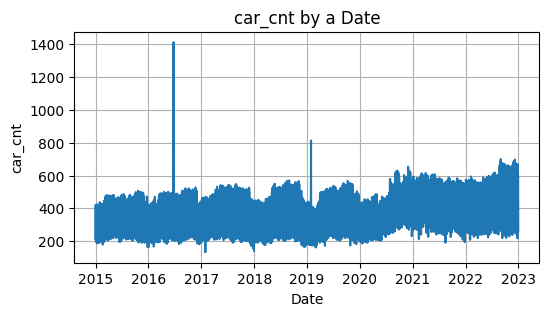

In [207]:
plt.figure(figsize=(6, 3))  # 그래프 크기 설정
sns.lineplot(data = taxi_copy, x ='Date', y='car_cnt')  # 라인 플롯 그리기

plt.title('car_cnt by a Date')  # 그래프 제목 설정
plt.xlabel('Date')  # x축 레이블 설정
plt.ylabel('car_cnt')  # y축 레이블 설정
plt.grid()  # 그리드 표시

* 접수건, 탑승건

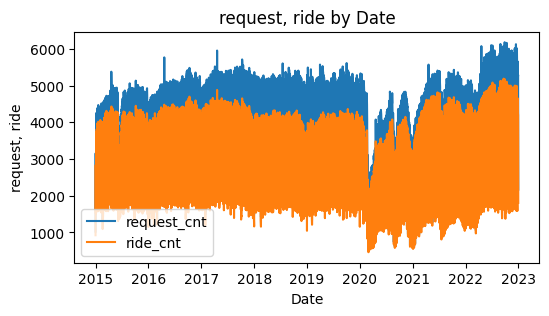

In [208]:
# 시각화
plt.figure(figsize=(6, 3))
sns.lineplot(data=taxi_copy, x='Date', y='request_cnt', label='request_cnt')
sns.lineplot(data=taxi_copy, x='Date', y='ride_cnt', label='ride_cnt')

plt.title('request, ride by Date')
plt.xlabel('Date')
plt.ylabel('request, ride')

# 범례
plt.legend()
plt.show()

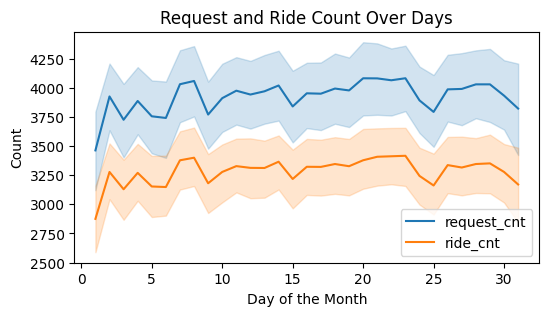

In [252]:
plt.figure(figsize=(6, 3))

taxi_copy['Day'] = taxi_copy['Date'].dt.day
data_to_plot = taxi_copy[['Day', 'request_cnt', 'ride_cnt']]

sns.lineplot(data=data_to_plot, x='Day', y='request_cnt', label='request_cnt')
sns.lineplot(data=data_to_plot, x='Day', y='ride_cnt', label='ride_cnt')

plt.title('Request and Ride Count Over Days')
plt.xlabel('Day of the Month')
plt.ylabel('Count')

plt.legend()
plt.show()

* 대기시간

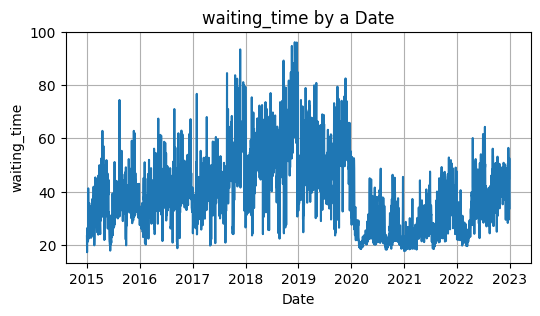

In [209]:
plt.figure(figsize=(6, 3))  # 그래프 크기 설정
sns.lineplot(data = taxi_copy, x ='Date', y='waiting_time')  # 라인 플롯 그리기

plt.title('waiting_time by a Date')  # 그래프 제목 설정
plt.xlabel('Date')  # x축 레이블 설정
plt.ylabel('waiting_time')  # y축 레이블 설정
plt.grid()  # 그리드 표시

* 운임

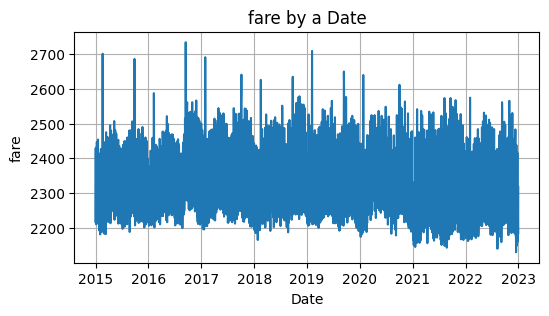

In [210]:
plt.figure(figsize=(6, 3))  # 그래프 크기 설정
sns.lineplot(data = taxi_copy, x ='Date', y='fare')  # 라인 플롯 그리기

plt.title('fare by a Date')  # 그래프 제목 설정
plt.xlabel('Date')  # x축 레이블 설정
plt.ylabel('fare')  # y축 레이블 설정
plt.grid()  # 그리드 표시

* 이동거리

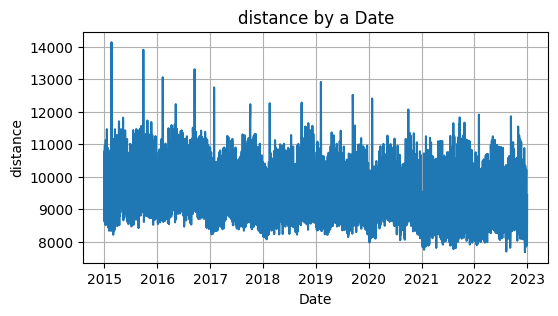

In [211]:
plt.figure(figsize=(6, 3))  # 그래프 크기 설정
sns.lineplot(data = taxi_copy, x ='Date', y='distance')  # 라인 플롯 그리기

plt.title('distance by a Date')  # 그래프 제목 설정
plt.xlabel('Date')  # x축 레이블 설정
plt.ylabel('distance')  # y축 레이블 설정
plt.grid()  # 그리드 표시

### (3) 요일별 (boxplot활용)

* 차량 운행수

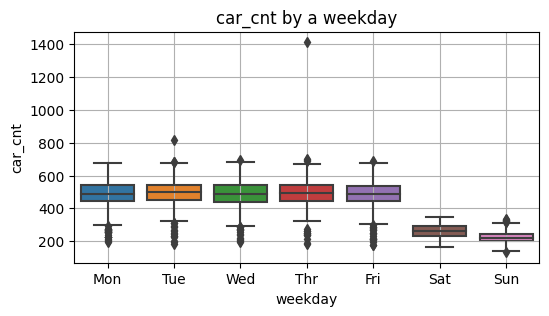

In [212]:
plt.figure(figsize=(6, 3))  # 그래프 크기 설정

sns.boxplot(x='weekday', y='car_cnt', data=taxi_copy)  # 박스 플롯 그리기    [orient='h']
plt.title('car_cnt by a weekday')  # 그래프 제목 설정
plt.xlabel('weekday')  # x축 레이블 설정
plt.ylabel('car_cnt')  # y축 레이블 설정
day_labels = ['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun']   # 라벨 이름 변경
plt.xticks(range(7), day_labels)

plt.grid()
plt.show()

* 접수건, 탑승건

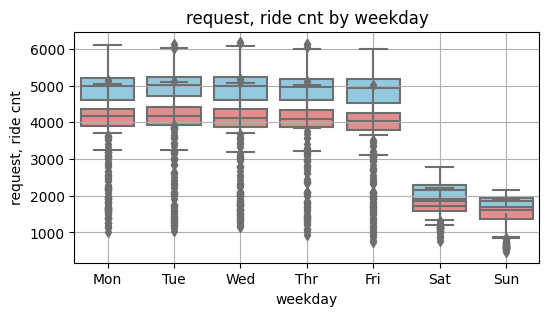

In [213]:
plt.figure(figsize=(6, 3))
sns.boxplot(x='weekday', y='request_cnt', data=taxi_copy, color='skyblue')  # 박스 플롯 그리기    [orient='h']
sns.boxplot(x='weekday', y='ride_cnt', data=taxi_copy, color='lightcoral')

plt.title('request, ride cnt by weekday')  # 그래프 제목 설정
plt.xlabel('weekday')  # x축 레이블 설정
plt.ylabel('request, ride cnt')  # y축 레이블 설정
day_labels = ['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun']   # 라벨 이름 변경
plt.xticks(range(7), day_labels)

plt.grid()
plt.show()

* 대기시간

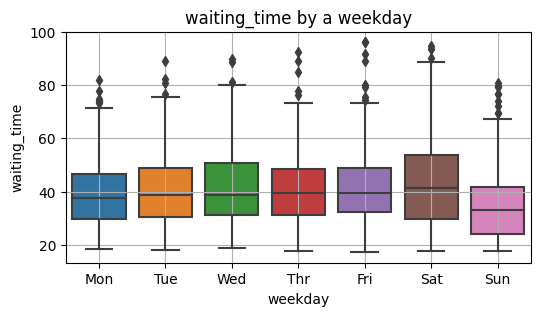

In [214]:
plt.figure(figsize=(6, 3))  # 그래프 크기 설정

sns.boxplot(x='weekday', y='waiting_time', data=taxi_copy)  # 박스 플롯 그리기    [orient='h']
plt.title('waiting_time by a weekday')  # 그래프 제목 설정
plt.xlabel('weekday')  # x축 레이블 설정
plt.ylabel('waiting_time')  # y축 레이블 설정
day_labels = ['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun']   # 라벨 이름 변경
plt.xticks(range(7), day_labels)

plt.grid()
plt.show()

* 운임

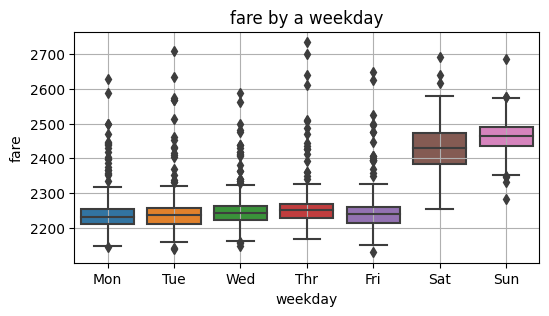

In [215]:
plt.figure(figsize=(6, 3))  # 그래프 크기 설정

sns.boxplot(x='weekday', y='fare', data=taxi_copy)  # 박스 플롯 그리기    [orient='h']
plt.title('fare by a weekday')  # 그래프 제목 설정
plt.xlabel('weekday')  # x축 레이블 설정
plt.ylabel('fare')  # y축 레이블 설정
day_labels = ['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun']   # 라벨 이름 변경
plt.xticks(range(7), day_labels)

plt.grid()
plt.show()

* 이동거리

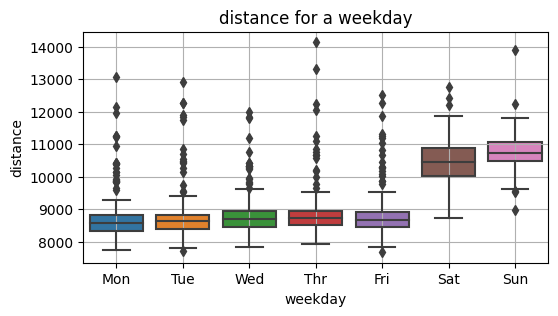

In [216]:
plt.figure(figsize=(6, 3))  # 그래프 크기 설정

sns.boxplot(x='weekday', y='distance', data=taxi_copy)  # 박스 플롯 그리기    [orient='h']
plt.title('distance for a weekday')  # 그래프 제목 설정
plt.xlabel('weekday')  # x축 레이블 설정
plt.ylabel('distance')  # y축 레이블 설정
day_labels = ['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun']   # 라벨 이름 변경
plt.xticks(range(7), day_labels)

plt.grid()
plt.show()

### (4) 월별 (boxplot활용)

* 차량 운행수

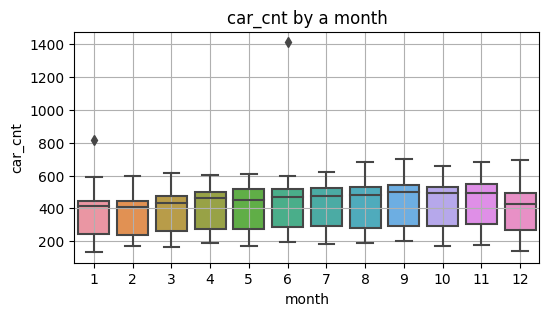

In [217]:
plt.figure(figsize=(6, 3))  # 그래프 크기 설정

sns.boxplot(x='month', y='car_cnt', data=taxi_copy)  # 박스 플롯 그리기    [orient='h']
plt.title('car_cnt by a month')  # 그래프 제목 설정
plt.xlabel('month')  # x축 레이블 설정
plt.ylabel('car_cnt')  # y축 레이블 설정

plt.grid()
plt.show()

* 접수건, 탑승건

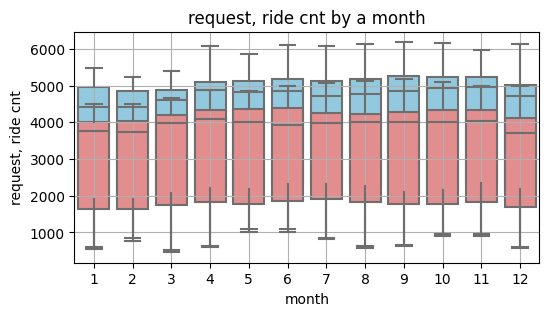

In [218]:
plt.figure(figsize=(6, 3))  # 그래프 크기 설정

sns.boxplot(x='month', y='request_cnt', data=taxi_copy, color='skyblue')  # 박스 플롯 그리기    [orient='h']
sns.boxplot(x='month', y='ride_cnt', data=taxi_copy, color='lightcoral')
plt.title('request, ride cnt by a month')  # 그래프 제목 설정
plt.xlabel('month')  # x축 레이블 설정
plt.ylabel('request, ride cnt')  # y축 레이블 설정

plt.grid()
plt.show()

* 대기시간

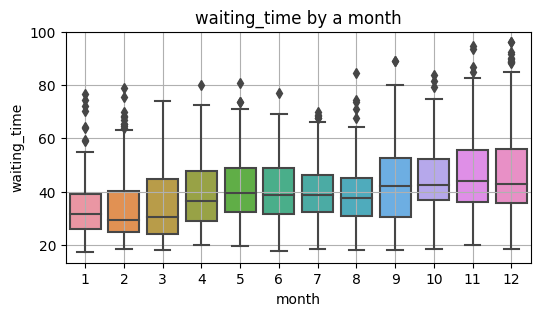

In [219]:
plt.figure(figsize=(6, 3))  # 그래프 크기 설정

sns.boxplot(x='month', y='waiting_time', data=taxi_copy)  # 박스 플롯 그리기    [orient='h']
plt.title('waiting_time by a month')  # 그래프 제목 설정
plt.xlabel('month')  # x축 레이블 설정
plt.ylabel('waiting_time')  # y축 레이블 설정

plt.grid()
plt.show()

* 운임

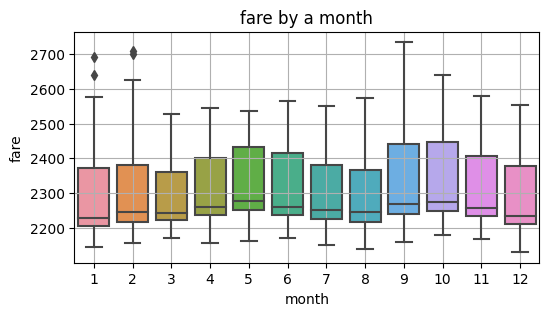

In [220]:
plt.figure(figsize=(6, 3))  # 그래프 크기 설정

sns.boxplot(x='month', y='fare', data=taxi_copy)  # 박스 플롯 그리기    [orient='h']
plt.title('fare by a month')  # 그래프 제목 설정
plt.xlabel('month')  # x축 레이블 설정
plt.ylabel('fare')  # y축 레이블 설정

plt.grid()
plt.show()

* 이동거리

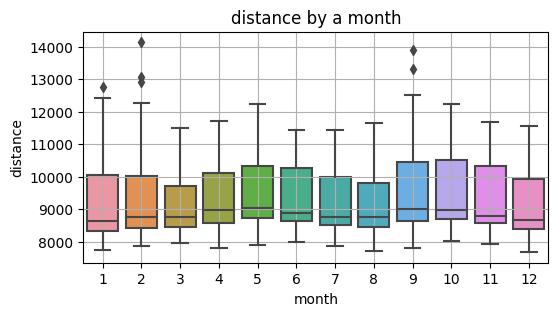

In [221]:
plt.figure(figsize=(6, 3))  # 그래프 크기 설정

sns.boxplot(x='month', y='distance', data=taxi_copy)  # 박스 플롯 그리기    [orient='h']
plt.title('distance by a month')  # 그래프 제목 설정
plt.xlabel('month')  # x축 레이블 설정
plt.ylabel('distance')  # y축 레이블 설정

plt.grid()
plt.show()

### (5) 연도별 (boxplot 활용)

* 차량 운행수

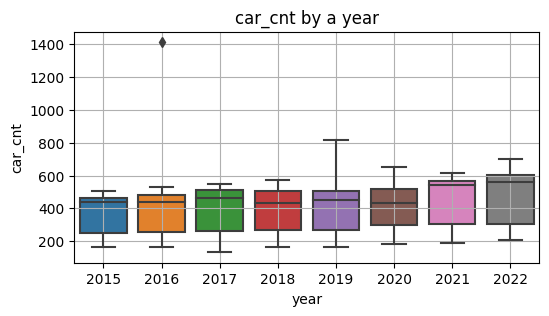

In [222]:
plt.figure(figsize=(6, 3))  # 그래프 크기 설정

sns.boxplot(x='year', y='car_cnt', data=taxi_copy)  # 박스 플롯 그리기    [orient='h']
plt.title('car_cnt by a year')  # 그래프 제목 설정
plt.xlabel('year')  # x축 레이블 설정
plt.ylabel('car_cnt')  # y축 레이블 설정

plt.grid()
plt.show()

* 접수건, 탑승건

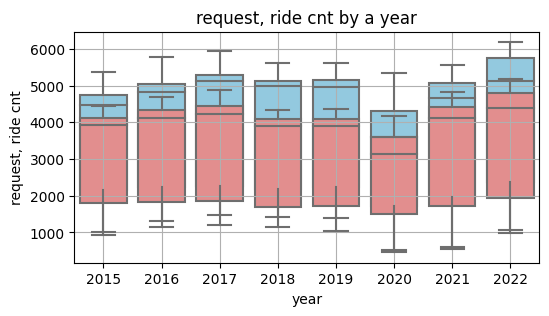

In [223]:
plt.figure(figsize=(6, 3))  # 그래프 크기 설정

sns.boxplot(x='year', y='request_cnt', data=taxi_copy, color='skyblue')  # 박스 플롯 그리기    [orient='h']
sns.boxplot(x='year', y='ride_cnt', data=taxi_copy, color='lightcoral')
plt.title('request, ride cnt by a year')  # 그래프 제목 설정
plt.xlabel('year')  # x축 레이블 설정
plt.ylabel('request, ride cnt')  # y축 레이블 설정

plt.grid()
plt.show()

* 대기시간

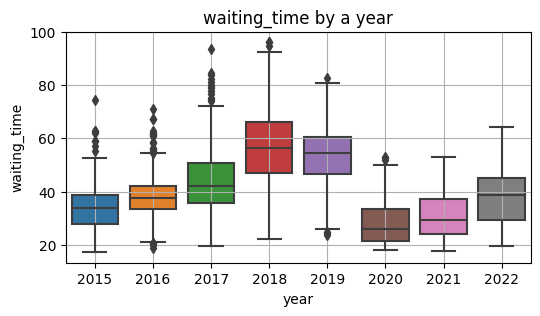

In [224]:
plt.figure(figsize=(6, 3))  # 그래프 크기 설정

sns.boxplot(x='year', y='waiting_time', data=taxi_copy)  # 박스 플롯 그리기    [orient='h']
plt.title('waiting_time by a year')  # 그래프 제목 설정
plt.xlabel('year')  # x축 레이블 설정
plt.ylabel('waiting_time')  # y축 레이블 설정

plt.grid()
plt.show()

* 운임

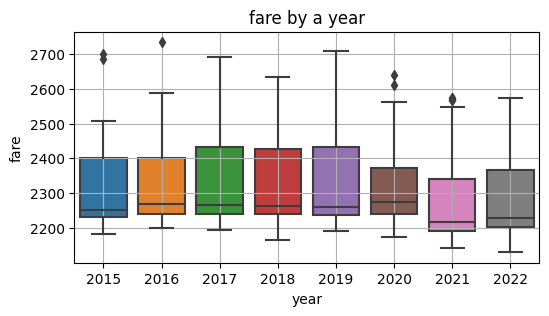

In [225]:
plt.figure(figsize=(6, 3))  # 그래프 크기 설정

sns.boxplot(x='year', y='fare', data=taxi_copy)  # 박스 플롯 그리기    [orient='h']
plt.title('fare by a year')  # 그래프 제목 설정
plt.xlabel('year')  # x축 레이블 설정
plt.ylabel('fare')  # y축 레이블 설정

plt.grid()
plt.show()

* 이동거리

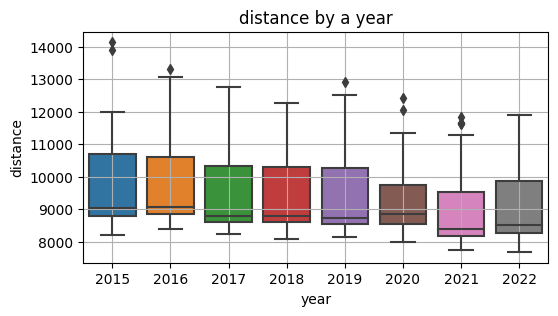

In [226]:
plt.figure(figsize=(6, 3))  # 그래프 크기 설정

sns.boxplot(x='year', y='distance', data=taxi_copy)  # 박스 플롯 그리기    [orient='h']
plt.title('distance by a year')  # 그래프 제목 설정
plt.xlabel('year')  # x축 레이블 설정
plt.ylabel('distance')  # y축 레이블 설정

plt.grid()
plt.show()

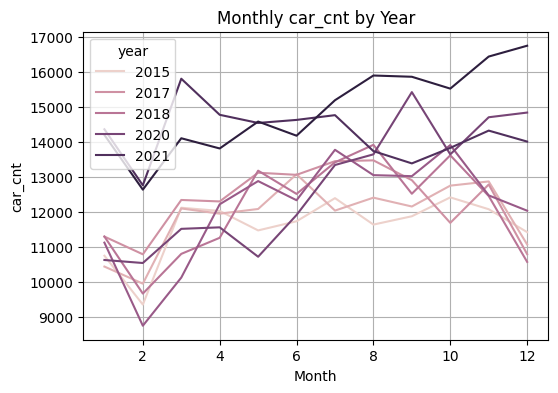

In [250]:
plt.figure(figsize=(6, 4))

# 데이터를 년도(year)와 월(month)로 그룹화하고 'car_cnt'의 합계 계산
monthly_car_cnt = taxi_copy.groupby(['year', 'month'])['car_cnt'].sum().reset_index()
sns.lineplot(data=monthly_car_cnt, x='month', y='car_cnt', hue='year')
plt.title('Monthly car_cnt by Year')
plt.xlabel('Month')
plt.ylabel('car_cnt')

plt.grid()
plt.show()

# 시간이 흐름에 따라 평균적인 이용량이 증가하는 경향을 보임

## 3.데이터 구조 만들기

* 목표 : 전날 저녁, 다음날 평균 대기시간을 예측
* 장애인 이동 데이터를 기준으로 날씨 데이터를 붙임

In [227]:
display(taxi_copy)
display(weather_data)

print('\n')
display(taxi_copy.info())
print('\n')
display(weather_data.info())

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,year,month,week,weekday
0,2015-01-01,213,1023,924,23.2,2427,10764,2015,1,1,3
1,2015-01-02,420,3158,2839,17.2,2216,8611,2015,1,1,4
2,2015-01-03,209,1648,1514,26.2,2377,10198,2015,1,1,5
3,2015-01-04,196,1646,1526,24.5,2431,10955,2015,1,1,6
4,2015-01-05,421,4250,3730,26.2,2214,8663,2015,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...
2917,2022-12-27,669,5635,4654,44.4,2198,8178,2022,12,52,1
2918,2022-12-28,607,5654,4648,44.8,2161,7882,2022,12,52,2
2919,2022-12-29,581,5250,4247,52.5,2229,8433,2022,12,52,3
2920,2022-12-30,600,5293,4200,38.3,2183,8155,2022,12,52,4


,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2012-01-01,0.4,-6.6,0.0,77.0,45.0,4.90
1,2012-01-02,-1.2,-8.3,0.0,80.0,48.0,6.16
2,2012-01-03,-0.4,-6.6,0.4,86.0,45.0,4.46
3,2012-01-04,-4.6,-9.5,0.0,66.0,38.0,8.05
4,2012-01-05,-1.4,-9.6,0.0,71.0,28.0,9.14
...,...,...,...,...,...,...,...
4013,2022-12-27,3.0,-7.3,0.0,86.0,51.0,10.25
4014,2022-12-28,-0.3,-5.4,0.1,92.0,40.0,10.86
4015,2022-12-29,1.7,-7.8,0.0,71.0,34.0,10.88
4016,2022-12-30,2.1,-4.0,0.0,87.0,38.0,10.84




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2922 non-null   datetime64[ns]
 1   car_cnt       2922 non-null   int64         
 2   request_cnt   2922 non-null   int64         
 3   ride_cnt      2922 non-null   int64         
 4   waiting_time  2922 non-null   float64       
 5   fare          2922 non-null   int64         
 6   distance      2922 non-null   int64         
 7   year          2922 non-null   int64         
 8   month         2922 non-null   int64         
 9   week          2922 non-null   UInt32        
 10  weekday       2922 non-null   int64         
dtypes: UInt32(1), datetime64[ns](1), float64(1), int64(8)
memory usage: 242.7 KB


None



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             4018 non-null   datetime64[ns]
 1   temp_max         4018 non-null   float64       
 2   temp_min         4018 non-null   float64       
 3   rain(mm)         4018 non-null   float64       
 4   humidity_max(%)  4018 non-null   float64       
 5   humidity_min(%)  4018 non-null   float64       
 6   sunshine(MJ/m2)  4018 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 219.9 KB


None

### (1) target 만들기
* 예측하는 날짜, 대기시간(target)으로 기준을 잡음

In [228]:
# 익일의 대기시간(waiting time)을 오늘의 데이터를 활용하여 예측 해야하는 대상(target)으로 설정
taxi_copy['target'] = taxi_copy['waiting_time'].shift(periods=-1, fill_value=0)

# waiting_time열 삭제
taxi_copy.drop(columns=['waiting_time'], inplace=True)

In [229]:
display(taxi_copy.head(2))
display(weather_data.head(2))

,Date,car_cnt,request_cnt,ride_cnt,fare,distance,year,month,week,weekday,target
0,2015-01-01,213,1023,924,2427,10764,2015,1,1,3,17.2
1,2015-01-02,420,3158,2839,2216,8611,2015,1,1,4,26.2


,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2012-01-01,0.4,-6.6,0.0,77.0,45.0,4.90
1,2012-01-02,-1.2,-8.3,0.0,80.0,48.0,6.16


### (2) 날씨 데이터 붙이기
* merge를 활용
* 기준은 운행정보

--  weather shift x  --

In [230]:
# 익일의 실제 날씨 데이터를 전일에 발표된 예보데이터로 판단
# merge한 후 첫번쨰 행 삭제

taxi_merge = pd.merge(taxi_copy, weather_data, how='inner', on='Date')
taxi_merge.head(2)

,Date,car_cnt,request_cnt,ride_cnt,fare,distance,year,month,week,weekday,target,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2015-01-01,213,1023,924,2427,10764,2015,1,1,3,17.2,-4.3,-9.8,0.0,52.0,33.0,9.79
1,2015-01-02,420,3158,2839,2216,8611,2015,1,1,4,26.2,-2.0,-8.9,0.0,63.0,28.0,9.07


### (3) 새로운 feature를 생성
* 날짜와 관련된 변수 추가 : 요일, 월, 계절, 연도
* 그외 새로운 feature 도출 : 공휴일, 최근 7주일간의 평균 대기시간, 탑승률 등

#### 1) 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 요일 이름, 계절이름, 월 이름으로 만드는 경우에는, 변수를 pd.Categorical로 범주형을 만들면서 순서를 지정하는 것이 이후 그래프를 그릴 때 순서대로 표현할 수 있습니다.


In [231]:
# 계절 추가하기
def get_season(month):
    if 3 <= month <= 5:
        return '봄'
    elif 6 <= month <= 8:
        return '여름'
    elif 9 <= month <= 11:
        return '가을'
    else:
        return '겨울'

taxi_merge['season'] = taxi_merge['month'].apply(get_season)
taxi_merge['season'] = pd.Categorical(taxi_merge['season'], categories=['봄', '여름', '가을', '겨울'], ordered=True)

taxi_merge.head()

,Date,car_cnt,request_cnt,ride_cnt,fare,distance,year,month,week,weekday,target,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),season
0,2015-01-01,213,1023,924,2427,10764,2015,1,1,3,17.2,-4.3,-9.8,0.0,52.0,33.0,9.79,겨울
1,2015-01-02,420,3158,2839,2216,8611,2015,1,1,4,26.2,-2.0,-8.9,0.0,63.0,28.0,9.07,겨울
2,2015-01-03,209,1648,1514,2377,10198,2015,1,1,5,24.5,2.4,-9.2,0.0,73.0,37.0,8.66,겨울
3,2015-01-04,196,1646,1526,2431,10955,2015,1,1,6,26.2,8.2,0.2,0.0,89.0,58.0,5.32,겨울
4,2015-01-05,421,4250,3730,2214,8663,2015,1,2,0,23.6,7.9,-0.9,0.0,95.0,52.0,6.48,겨울


In [232]:
# weekday 바꾸기
weekday_mapping = {
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thr',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun'
}

taxi_merge['weekday'] = taxi_merge['weekday'].map(weekday_mapping)
# taxi_merge['weekday'] = pd.Categorical(taxi_merge['weekday'], categories=['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun'])

taxi_merge.head()

,Date,car_cnt,request_cnt,ride_cnt,fare,distance,year,month,week,weekday,target,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),season
0,2015-01-01,213,1023,924,2427,10764,2015,1,1,Thr,17.2,-4.3,-9.8,0.0,52.0,33.0,9.79,겨울
1,2015-01-02,420,3158,2839,2216,8611,2015,1,1,Fri,26.2,-2.0,-8.9,0.0,63.0,28.0,9.07,겨울
2,2015-01-03,209,1648,1514,2377,10198,2015,1,1,Sat,24.5,2.4,-9.2,0.0,73.0,37.0,8.66,겨울
3,2015-01-04,196,1646,1526,2431,10955,2015,1,1,Sun,26.2,8.2,0.2,0.0,89.0,58.0,5.32,겨울
4,2015-01-05,421,4250,3730,2214,8663,2015,1,2,Mon,23.6,7.9,-0.9,0.0,95.0,52.0,6.48,겨울


In [233]:
taxi_merge.isna().sum()

Date               0
car_cnt            0
request_cnt        0
ride_cnt           0
fare               0
distance           0
year               0
month              0
week               0
weekday            0
target             0
temp_max           0
temp_min           0
rain(mm)           0
humidity_max(%)    0
humidity_min(%)    0
sunshine(MJ/m2)    0
season             0
dtype: int64

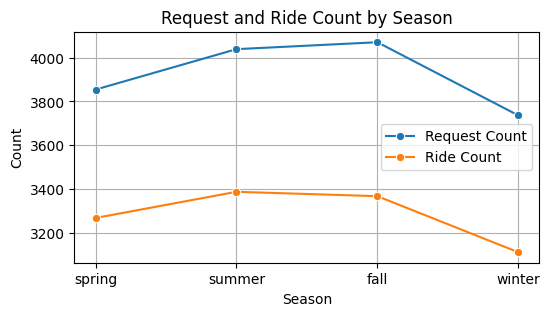

In [237]:
# 데이터를 계절별로 그룹화하고 각 계절의 탑승 건과 접수 건 평균을 계산
seasonal_data = taxi_merge.groupby('season')[['request_cnt', 'ride_cnt']].mean().reset_index()

# 계절 레이블 변경
seasonal_data['season'] = seasonal_data['season'].map({
    '봄': 'spring',
    '여름': 'summer',
    '가을': 'fall',
    '겨울': 'winter'
})

# 그래프 그리기
plt.figure(figsize=(6, 3))
sns.lineplot(data=seasonal_data, x='season', y='request_cnt', label='Request Count', marker='o')
sns.lineplot(data=seasonal_data, x='season', y='ride_cnt', label='Ride Count', marker='o')

plt.title('Request and Ride Count by Season')
plt.xlabel('Season')
plt.ylabel('Count')

plt.legend()
plt.grid()
plt.show()


#### 2) 공휴일 정보
* workalendar 패키지를 설치하고, 대한민국 공휴일 정보를 가져옴

* 휴무일 데이터 패키지 설치

In [238]:
!pip install workalendar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732001 sha256=b4a754afffb87b2ce9ac0ff8412c54e6a2f8c0110ca0244dc3bd24e589656ad6
  Stored in directory: /root/.cache/pip/wheels/d6/67/78/aa2e8d108639dd23a5e9e72a4fc88bb44f5541894382712f48
Successfully built pymeeus


* 간단 사용법

In [239]:
from workalendar.asia import SouthKorea
cal = SouthKorea()
pd.DataFrame(cal.holidays(2023))

,0,1
0,2023-01-01,New year
1,2023-01-21,Korean New Year's Day
2,2023-01-22,Korean New Year's Day
3,2023-01-23,Korean New Year's Day
4,2023-03-01,Independence Day
5,2023-05-05,Children's Day
6,2023-05-26,Buddha's Birthday
7,2023-06-06,Memorial Day
8,2023-08-15,Liberation Day
9,2023-09-28,Midautumn Festival


* 휴무일 데이터셋 만들기 2015 ~ 2022
* 실제로 휴무일에 해당하지만 workalendar 라이브러리에 없는 날짜는 직접 추가
    * 휴무일 장애인 콜택시의 접수건 변화에 대한 특징을 찾아 이를 바탕으로 데이터를 조회하여 찾아볼 수 있음

In [240]:
import pandas as pd
from workalendar.asia import SouthKorea

date_range = pd.date_range(start='2015-01-01', end='2022-12-31')

cal = SouthKorea()

holidays = []
for year in range(2015, 2023):
    year_holidays = cal.holidays(year)
    holidays.extend(year_holidays)

# 휴무일 데이터프레임 생성
holidays_df = pd.DataFrame(holidays, columns=['Date', 'Holiday_Name'])

# 휴무일 데이터프레임 출력
print(holidays_df)

           Date             Holiday_Name
0    2015-01-01                 New year
1    2015-02-18    Korean New Year's Day
2    2015-02-19    Korean New Year's Day
3    2015-02-20    Korean New Year's Day
4    2015-03-01         Independence Day
..          ...                      ...
115  2022-09-10       Midautumn Festival
116  2022-09-11       Midautumn Festival
117  2022-10-03  National Foundation Day
118  2022-10-09               Hangul Day
119  2022-12-25            Christmas Day

[120 rows x 2 columns]


* 기존 데이터에 휴무일 정보 결합
* 휴무일이 아닌 날짜는 0으로 저장

In [241]:
holidays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          120 non-null    object
 1   Holiday_Name  120 non-null    object
dtypes: object(2)
memory usage: 2.0+ KB


In [242]:
# 휴무일 날짜 datatime으로 변경
holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

In [243]:
# 기존 데이터에 휴무일 정보 결합 + 휴무일이 아닌 날짜는 0으로 저장
#taxi_holidays = pd.merge(taxi_copy, holidays_df,how='inner', on='Date')
taxi_holidays = taxi_merge.merge(holidays_df, how='left', on='Date')
taxi_holidays['Holiday_Name'].fillna(0, inplace=True)
taxi_holidays.head()

,Date,car_cnt,request_cnt,ride_cnt,fare,distance,year,month,week,weekday,target,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),season,Holiday_Name
0,2015-01-01,213,1023,924,2427,10764,2015,1,1,Thr,17.2,-4.3,-9.8,0.0,52.0,33.0,9.79,겨울,New year
1,2015-01-02,420,3158,2839,2216,8611,2015,1,1,Fri,26.2,-2.0,-8.9,0.0,63.0,28.0,9.07,겨울,0
2,2015-01-03,209,1648,1514,2377,10198,2015,1,1,Sat,24.5,2.4,-9.2,0.0,73.0,37.0,8.66,겨울,0
3,2015-01-04,196,1646,1526,2431,10955,2015,1,1,Sun,26.2,8.2,0.2,0.0,89.0,58.0,5.32,겨울,0
4,2015-01-05,421,4250,3730,2214,8663,2015,1,2,Mon,23.6,7.9,-0.9,0.0,95.0,52.0,6.48,겨울,0


#### 3) 7일 이동평균 대기시간
* rolling().mean() 사용

In [244]:
# 'Date'를 인덱스로
taxi_holidays.set_index('Date', inplace=True)

# 7일 이동평균 대기시간 계산
taxi_holidays['7day_waiting_time_mean'] = taxi_holidays['target'].rolling(window=7,min_periods=1).mean()

# 결과 확인
taxi_holidays.head(10)

,car_cnt,request_cnt,ride_cnt,fare,distance,year,month,week,weekday,target,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),season,Holiday_Name,7day_waiting_time_mean
Date,,,,,,,,,,,,,,,,,,,
2015-01-01,213,1023,924,2427,10764,2015,1,1,Thr,17.2,-4.3,-9.8,0.0,52.0,33.0,9.79,겨울,New year,17.200000
2015-01-02,420,3158,2839,2216,8611,2015,1,1,Fri,26.2,-2.0,-8.9,0.0,63.0,28.0,9.07,겨울,0,21.700000
2015-01-03,209,1648,1514,2377,10198,2015,1,1,Sat,24.5,2.4,-9.2,0.0,73.0,37.0,8.66,겨울,0,22.633333
2015-01-04,196,1646,1526,2431,10955,2015,1,1,Sun,26.2,8.2,0.2,0.0,89.0,58.0,5.32,겨울,0,23.525000
2015-01-05,421,4250,3730,2214,8663,2015,1,2,Mon,23.6,7.9,-0.9,0.0,95.0,52.0,6.48,겨울,0,23.540000
2015-01-06,417,3991,3633,2211,8545,2015,1,2,Tue,24.7,4.1,-7.4,3.4,98.0,29.0,10.47,겨울,0,23.733333
2015-01-07,410,4085,3676,2230,8646,2015,1,2,Wed,21.2,-1.0,-8.8,0.0,42.0,24.0,10.12,겨울,0,23.371429
2015-01-08,419,4030,3728,2231,8683,2015,1,2,Thr,21.8,-0.2,-9.2,0.0,62.0,27.0,10.09,겨울,0,24.028571
2015-01-09,424,4167,3813,2215,8506,2015,1,2,Fri,41.2,3.2,-6.8,0.0,78.0,38.0,8.74,겨울,0,26.171429


In [245]:
# 30일 이동평균 대기시간 계산
taxi_holidays['30day_waiting_time_mean'] = taxi_holidays['target'].rolling(window=30,min_periods=1).mean()

# 결과 확인
taxi_holidays.head(10)

,car_cnt,request_cnt,ride_cnt,fare,distance,year,month,week,weekday,target,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),season,Holiday_Name,7day_waiting_time_mean,30day_waiting_time_mean
Date,,,,,,,,,,,,,,,,,,,,
2015-01-01,213,1023,924,2427,10764,2015,1,1,Thr,17.2,-4.3,-9.8,0.0,52.0,33.0,9.79,겨울,New year,17.200000,17.200000
2015-01-02,420,3158,2839,2216,8611,2015,1,1,Fri,26.2,-2.0,-8.9,0.0,63.0,28.0,9.07,겨울,0,21.700000,21.700000
2015-01-03,209,1648,1514,2377,10198,2015,1,1,Sat,24.5,2.4,-9.2,0.0,73.0,37.0,8.66,겨울,0,22.633333,22.633333
2015-01-04,196,1646,1526,2431,10955,2015,1,1,Sun,26.2,8.2,0.2,0.0,89.0,58.0,5.32,겨울,0,23.525000,23.525000
2015-01-05,421,4250,3730,2214,8663,2015,1,2,Mon,23.6,7.9,-0.9,0.0,95.0,52.0,6.48,겨울,0,23.540000,23.540000
2015-01-06,417,3991,3633,2211,8545,2015,1,2,Tue,24.7,4.1,-7.4,3.4,98.0,29.0,10.47,겨울,0,23.733333,23.733333
2015-01-07,410,4085,3676,2230,8646,2015,1,2,Wed,21.2,-1.0,-8.8,0.0,42.0,24.0,10.12,겨울,0,23.371429,23.371429
2015-01-08,419,4030,3728,2231,8683,2015,1,2,Thr,21.8,-0.2,-9.2,0.0,62.0,27.0,10.09,겨울,0,24.028571,23.175000
2015-01-09,424,4167,3813,2215,8506,2015,1,2,Fri,41.2,3.2,-6.8,0.0,78.0,38.0,8.74,겨울,0,26.171429,25.177778


#### 4) 탑승률

In [246]:
taxi_holidays['ride_percentage'] = (taxi_holidays['ride_cnt'] / taxi_holidays['request_cnt']) * 100
taxi_holidays.head()

,car_cnt,request_cnt,ride_cnt,fare,distance,year,month,week,weekday,target,...,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),season,Holiday_Name,7day_waiting_time_mean,30day_waiting_time_mean,ride_percentage
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,213,1023,924,2427,10764,2015,1,1,Thr,17.2,...,-9.8,0.0,52.0,33.0,9.79,겨울,New year,17.200000,17.200000,90.322581
2015-01-02,420,3158,2839,2216,8611,2015,1,1,Fri,26.2,...,-8.9,0.0,63.0,28.0,9.07,겨울,0,21.700000,21.700000,89.898670
2015-01-03,209,1648,1514,2377,10198,2015,1,1,Sat,24.5,...,-9.2,0.0,73.0,37.0,8.66,겨울,0,22.633333,22.633333,91.868932
2015-01-04,196,1646,1526,2431,10955,2015,1,1,Sun,26.2,...,0.2,0.0,89.0,58.0,5.32,겨울,0,23.525000,23.525000,92.709599
2015-01-05,421,4250,3730,2214,8663,2015,1,2,Mon,23.6,...,-0.9,0.0,95.0,52.0,6.48,겨울,0,23.540000,23.540000,87.764706


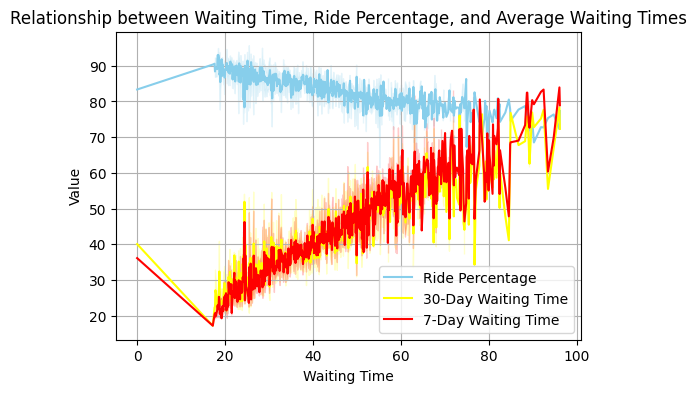

In [249]:
plt.figure(figsize=(6, 4))

# 대기 시간에 따른 탑승률 그래프
sns.lineplot(data=taxi_holidays, x='target', y='ride_percentage', color='skyblue', label='Ride Percentage')

# 평균 30일 대기시간에 따른 그래프
sns.lineplot(data=taxi_holidays, x='target', y='30day_waiting_time_mean', color='yellow', label='30-Day Waiting Time')

# 평균 7일 대기시간에 따른 그래프
sns.lineplot(data=taxi_holidays, x='target', y='7day_waiting_time_mean', color='red', label='7-Day Waiting Time')

plt.xlabel('Waiting Time')
plt.ylabel('Value')
plt.title('Relationship between Waiting Time, Ride Percentage, and Average Waiting Times')
plt.legend()
plt.grid()
plt.show()

## 4.데이터 저장
* joblib 을 사용하여 작업 경로에 정리한 데이터프레임을 저장

In [ ]:
file_path = 'data1.pkl'
joblib.dump(taxi_holidays, file_path)

# 저장한 데이터프레임 확인
print("taxi_holidays데이터 data1.pkl로 저장 완료!")

taxi_holidays데이터 data1.pkl로 저장 완료!
